In [1]:
import warnings; 
warnings.simplefilter('ignore')

In [2]:
!pip install pystan
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  ERROR: Command errored out with exit status 1:
   command: /Users/rakeshnagarajappa/opt/anaconda3/envs/fbpro/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/gw/8x9qmfqj6q38yzcz4q6rv4sc0000gn/T/pip-install-2u93psqm/fbprophet_c13f0557c1834271a5da79d9c32b0380/setup.py'"'"'; __file__='"'"'/private/var/folders/gw/8x9qmfqj6q38yzcz4q6rv4sc0000gn/T/pip-install-2u93psqm/fbprophet_c13f0557c1834271a5da79d9c32b0380/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/gw/8x9qmfqj6q38yzcz4q6rv4sc0000gn/T/pip-wheel-8477988_
       cwd: /private/var/folders/gw/8x9qmfqj6q38yzcz4q6rv4sc0000gn/T/pip-install-2u93psqm/fbprophet_c13f0557c1834271a5da79d9c32b0380/
  Complete output (10 lines):
  running bdist_wheel
  running build
  running build_py
  creating bui

In [5]:
import pandas as pd
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [123]:
df=pd.read_csv("../dataset/CaliforniaVaccination.csv",usecols=[0,7])

In [171]:
county = pd.read_csv("../dataset/CountyWiseCases.csv")
county.head()

,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
0,2021-04-24,Alameda,County,1685886.0,0.0,0.0,NaN,NaN,81.0,1.0,7720.0
1,2021-04-24,Alpine,County,1117.0,0.0,0.0,NaN,NaN,0.0,0.0,4.0
2,2021-04-24,Amador,County,38531.0,0.0,0.0,NaN,NaN,3.0,0.0,148.0
3,2021-04-24,Butte,County,217769.0,0.0,0.0,NaN,NaN,6.0,0.0,287.0
4,2021-04-24,Calaveras,County,44289.0,0.0,0.0,NaN,NaN,3.0,0.0,95.0


In [172]:
county['date'] = pd.DatetimeIndex(county['date'])
county.dtypes

date               datetime64[ns]
area                       object
area_type                  object
population                float64
cases                     float64
deaths                    float64
total_tests               float64
positive_tests            float64
reported_cases            float64
reported_deaths           float64
reported_tests            float64
dtype: object

In [191]:
#Getting the county wise data
import datetime
df = county.loc[(county["area"] == "Santa Clara")]
df.head(7)

,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
44,2021-04-24,Santa Clara,County,1967585.0,0.0,0.0,NaN,NaN,81.0,3.0,14233.0
105,2021-04-23,Santa Clara,County,1967585.0,2.0,0.0,307.0,3.0,136.0,11.0,17467.0
166,2021-04-22,Santa Clara,County,1967585.0,25.0,1.0,9686.0,40.0,139.0,8.0,14561.0
227,2021-04-21,Santa Clara,County,1967585.0,100.0,0.0,14053.0,122.0,90.0,2.0,21885.0
288,2021-04-20,Santa Clara,County,1967585.0,115.0,0.0,17421.0,141.0,129.0,0.0,7178.0
349,2021-04-19,Santa Clara,County,1967585.0,142.0,0.0,21511.0,177.0,103.0,0.0,8393.0
410,2021-04-18,Santa Clara,County,1967585.0,86.0,0.0,5373.0,102.0,109.0,0.0,14698.0


In [212]:
cs = df[df['date'] > '2021-04-16']
cs = cs[1:]
#calculating current number of cases per 100k
mean = cs.agg({'reported_cases': ['mean']})
population = cs.population.unique()
div = population[0]/100000
curr_cases = mean['reported_cases']/div
print(mean['reported_cases'],population[0],curr_cases)

mean    128.571429
Name: reported_cases, dtype: float64 1967585.0 mean    6.534479
Name: reported_cases, dtype: float64


In [216]:
#calculating average positive tests
c_sum = 0;
for index, row in cs.iterrows():
    t_avg = (row['positive_tests']/row['reported_tests'])*100
    c_sum +=t_avg
pos = c_sum/7;
pos
    

0.8946596701666224

In [182]:
#Filtering the county data for prediction 
df = df[df['date'] > '2020-12-01']
df = df[["date","reported_cases"]]
df.tail()


,date,reported_cases
8523,2020-12-06,773.0
8584,2020-12-05,874.0
8645,2020-12-04,844.0
8706,2020-12-03,743.0
8767,2020-12-02,481.0


In [140]:
df.tail()

,date,reported_cases
8479,2020-12-06,696.0
8540,2020-12-05,910.0
8601,2020-12-04,687.0
8662,2020-12-03,487.0
8723,2020-12-02,445.0


In [128]:
df.describe()

,reported_cases
count,388.000000
mean,220.951031
std,271.655904
min,-788.000000
25%,67.750000
50%,113.000000
75%,247.750000
max,2317.000000


In [183]:
#setting the date time index on date column
df['ds'] = pd.DatetimeIndex(df['date'])
df.drop('date', axis=1, inplace=True)
df_train = df[0:]

In [118]:
df_test = df[75:]
df_test.head()

,reported_cases,ds
4575,235.0,2021-02-08
4636,330.0,2021-02-07
4697,454.0,2021-02-06
4758,294.0,2021-02-05
4819,454.0,2021-02-04


In [98]:
df.dtypes

reported_cases           float64
ds                datetime64[ns]
dtype: object

In [184]:
#renaming the columns as required by the prophet
df_train.columns = ['y','ds']
df_train.tail()

,y,ds
8523,773.0,2020-12-06
8584,874.0,2020-12-05
8645,844.0,2020-12-04
8706,743.0,2020-12-03
8767,481.0,2020-12-02


In [102]:
#calling the vaccination predictor function
fore = predictor(df_train)
fore.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
88,2021-05-08,-129.821549,39512345,32.828128,190.644671,-138.877997,-121.048373,242.337841,242.337841,242.337841,217.074156,217.074156,217.074156,25.263685,25.263685,25.263685,0.0,0.0,0.0,112.516292
89,2021-05-09,-130.015251,39512345,5.422501,161.410879,-139.981179,-120.274770,214.681543,214.681543,214.681543,217.074156,217.074156,217.074156,-2.392613,-2.392613,-2.392613,0.0,0.0,0.0,84.666291
90,2021-05-10,-130.208954,39512345,-10.432191,147.022458,-141.325991,-119.559875,195.599512,195.599512,195.599512,217.074156,217.074156,217.074156,-21.474644,-21.474644,-21.474644,0.0,0.0,0.0,65.390558
91,2021-05-11,-130.402656,39512345,-12.828033,147.412515,-142.899841,-118.690155,196.237931,196.237931,196.237931,217.074156,217.074156,217.074156,-20.836225,-20.836225,-20.836225,0.0,0.0,0.0,65.835274
92,2021-05-12,-130.596359,39512345,1.923136,144.708369,-144.061890,-117.737419,201.744540,201.744540,201.744540,217.074156,217.074156,217.074156,-15.329615,-15.329615,-15.329615,0.0,0.0,0.0,71.148181


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-09,13.571438,39512345,133.278327,281.986688,13.571438,13.571438,196.237931,196.237931,196.237931,217.074156,217.074156,217.074156,-20.836225,-20.836225,-20.836225,0.0,0.0,0.0,209.809369
1,2021-02-10,9.166224,39512345,138.096104,288.794168,9.166224,9.166224,201.744540,201.744540,201.744540,217.074156,217.074156,217.074156,-15.329615,-15.329615,-15.329615,0.0,0.0,0.0,210.910764
2,2021-02-11,4.761009,39512345,136.537724,286.609179,4.761009,4.761009,207.978419,207.978419,207.978419,217.074156,217.074156,217.074156,-9.095737,-9.095737,-9.095737,0.0,0.0,0.0,212.739427
3,2021-02-12,0.355794,39512345,187.662659,337.887927,0.355794,0.355794,260.939304,260.939304,260.939304,217.074156,217.074156,217.074156,43.865149,43.865149,43.865149,0.0,0.0,0.0,261.295098
4,2021-02-13,-4.049421,39512345,162.289102,312.521977,-4.049421,-4.049421,242.337841,242.337841,242.337841,217.074156,217.074156,217.074156,25.263685,25.263685,25.263685,0.0,0.0,0.0,238.288420


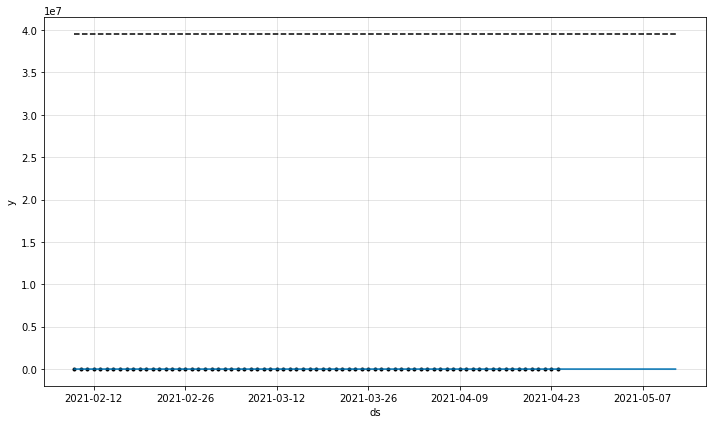

In [103]:
#vaccination predictor function
def predictor(df_train):
    m = Prophet(interval_width=0.95, daily_seasonality=True)
    model = m.fit(df_train)
    future = m.make_future_dataframe(periods=18,freq='D')
    future['cap'] = 39512345
    forecast = m.predict(future)
    return forecast
    forecast.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-19,15597.376214,39512345,223019.945903,302174.185217,15597.376214,15597.376214,245959.420842,245959.420842,245959.420842,249555.765403,249555.765403,249555.765403,-3596.344561,-3596.344561,-3596.344561,0.0,0.0,0.0,261556.797056
1,2021-01-20,33031.118913,39512345,229867.151905,306157.936441,33031.118913,33031.118913,234208.650266,234208.650266,234208.650266,249555.765403,249555.765403,249555.765403,-15347.115138,-15347.115138,-15347.115138,0.0,0.0,0.0,267239.769179
2,2021-01-21,50464.861612,39512345,235761.449170,316369.240208,50464.861612,50464.861612,225936.402770,225936.402770,225936.402770,249555.765403,249555.765403,249555.765403,-23619.362634,-23619.362634,-23619.362634,0.0,0.0,0.0,276401.264382
3,2021-01-22,67898.604304,39512345,269030.218586,350266.523965,67898.604304,67898.604304,240738.609768,240738.609768,240738.609768,249555.765403,249555.765403,249555.765403,-8817.155635,-8817.155635,-8817.155635,0.0,0.0,0.0,308637.214073
4,2021-01-23,85332.346996,39512345,311021.136990,390774.876713,85332.346996,85332.346996,265754.933793,265754.933793,265754.933793,249555.765403,249555.765403,249555.765403,16199.168389,16199.168389,16199.168389,0.0,0.0,0.0,351087.280789


In [10]:
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
106,2021-05-05,1.114897e+07,39512345,9.561818e+06,1.302762e+07,9.306276e+06,1.279408e+07,234208.650266,234208.650266,234208.650266,249555.765403,249555.765403,249555.765403,-15347.115138,-15347.115138,-15347.115138,0.0,0.0,0.0,1.138317e+07
107,2021-05-06,1.129249e+07,39512345,9.573073e+06,1.324305e+07,9.385848e+06,1.303607e+07,225936.402770,225936.402770,225936.402770,249555.765403,249555.765403,249555.765403,-23619.362634,-23619.362634,-23619.362634,0.0,0.0,0.0,1.151842e+07
108,2021-05-07,1.143601e+07,39512345,9.691749e+06,1.351736e+07,9.452907e+06,1.325175e+07,240738.609768,240738.609768,240738.609768,249555.765403,249555.765403,249555.765403,-8817.155635,-8817.155635,-8817.155635,0.0,0.0,0.0,1.167675e+07
109,2021-05-08,1.157953e+07,39512345,9.782547e+06,1.374943e+07,9.520233e+06,1.347092e+07,265754.933792,265754.933792,265754.933792,249555.765403,249555.765403,249555.765403,16199.168389,16199.168389,16199.168389,0.0,0.0,0.0,1.184528e+07
110,2021-05-09,1.172305e+07,39512345,9.829488e+06,1.395953e+07,9.578766e+06,1.368497e+07,269371.060089,269371.060089,269371.060089,249555.765403,249555.765403,249555.765403,19815.294685,19815.294685,19815.294685,0.0,0.0,0.0,1.199242e+07


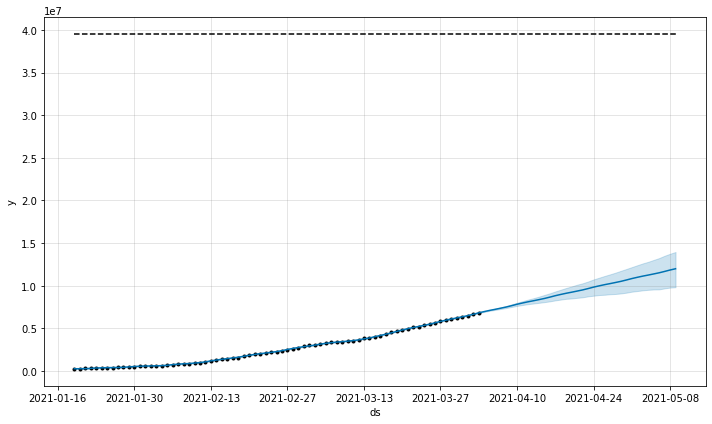

In [11]:
plot1 = m.plot(forecast)

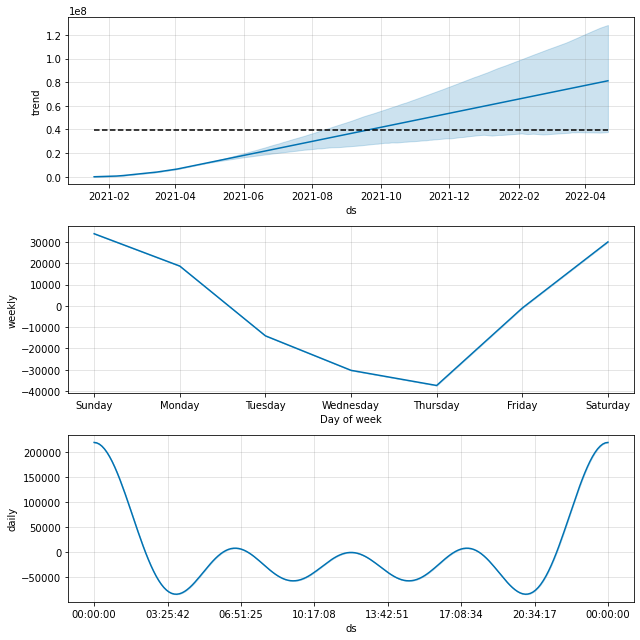

In [22]:
plt2 = m.plot_components(forecast)

In [53]:
forecast[['ds','yhat']]

,ds,yhat
0,2021-01-19,2.615568e+05
1,2021-01-20,2.672398e+05
2,2021-01-21,2.764013e+05
3,2021-01-22,3.086372e+05
4,2021-01-23,3.510873e+05
...,...,...
106,2021-05-05,1.138317e+07
107,2021-05-06,1.151842e+07
108,2021-05-07,1.167675e+07
109,2021-05-08,1.184528e+07


In [28]:
df_forcasted = forecast[75:]
df_forcasted.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
75,2021-04-04,6.699833e+06,39512345,6.928128e+06,7.012975e+06,6.687867e+06,6.709313e+06,269371.060089,269371.060089,269371.060089,249555.765403,249555.765403,249555.765403,19815.294685,19815.294685,19815.294685,0.0,0.0,0.0,6.969204e+06
76,2021-04-05,6.843353e+06,39512345,7.057227e+06,7.154636e+06,6.806071e+06,6.871077e+06,264921.280296,264921.280296,264921.280296,249555.765403,249555.765403,249555.765403,15365.514893,15365.514893,15365.514893,0.0,0.0,0.0,7.108274e+06
77,2021-04-06,6.986874e+06,39512345,7.163463e+06,7.293300e+06,6.921464e+06,7.036297e+06,245959.420842,245959.420842,245959.420842,249555.765403,249555.765403,249555.765403,-3596.344561,-3596.344561,-3596.344561,0.0,0.0,0.0,7.232833e+06
78,2021-04-07,7.130394e+06,39512345,7.259691e+06,7.452610e+06,7.031764e+06,7.208849e+06,234208.650266,234208.650266,234208.650266,249555.765403,249555.765403,249555.765403,-15347.115138,-15347.115138,-15347.115138,0.0,0.0,0.0,7.364603e+06
79,2021-04-08,7.273914e+06,39512345,7.366506e+06,7.614924e+06,7.143280e+06,7.379164e+06,225936.402770,225936.402770,225936.402770,249555.765403,249555.765403,249555.765403,-23619.362634,-23619.362634,-23619.362634,0.0,0.0,0.0,7.499851e+06


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [29]:
p_error = mean_squared_error(df_test.people_fully_vaccinated,df_forcasted.yhat)

In [30]:
np.sqrt(p_error)

554440.755476227

In [185]:
#prediction model for active cases in county
m = Prophet(interval_width=0.95,changepoint_prior_scale=0.8)
    model = m.fit(df_train)
    future = m.make_future_dataframe(periods=90,freq='D')
    forecast = m.predict(future)
    forecast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-02,854.217703,221.019050,1219.884262,854.217703,854.217703,-122.405016,-122.405016,-122.405016,-122.405016,-122.405016,-122.405016,0.0,0.0,0.0,731.812688
1,2020-12-03,884.965013,473.138562,1469.934544,884.965013,884.965013,87.426969,87.426969,87.426969,87.426969,87.426969,87.426969,0.0,0.0,0.0,972.391982
2,2020-12-04,915.712323,465.117662,1478.730645,915.712323,915.712323,70.155529,70.155529,70.155529,70.155529,70.155529,70.155529,0.0,0.0,0.0,985.867852
3,2020-12-05,946.459633,482.429440,1481.348097,946.459633,946.459633,61.370781,61.370781,61.370781,61.370781,61.370781,61.370781,0.0,0.0,0.0,1007.830415
4,2020-12-06,977.206944,503.449473,1483.858493,977.206944,977.206944,36.409366,36.409366,36.409366,36.409366,36.409366,36.409366,0.0,0.0,0.0,1013.616310


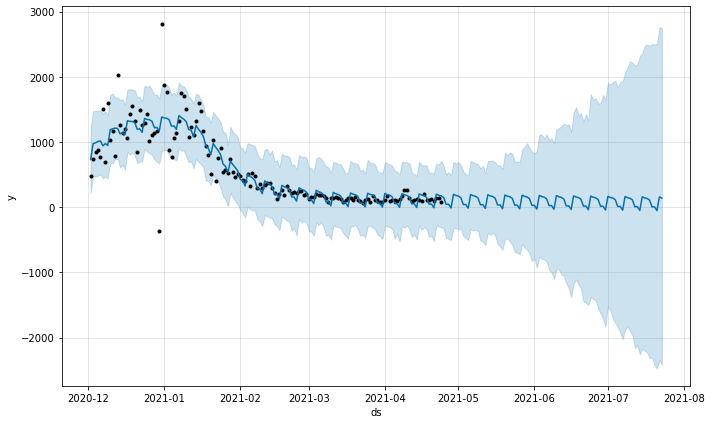

In [186]:
plot1 = m.plot(forecast)

In [221]:
forecast[['ds','yhat']].iloc[0,1]

731.8126878219374